# **Classifying facial expressions**

In [1]:
# Module imports
import random

import numpy as np
import pandas as pd

# Various performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Various components of an ML pipeline
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# For feature engineering
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp2d

# And a few actual models
from sklearn.svm import LinearSVC    #  For q's a, b and c
from xgboost import XGBClassifier    #  For the FUN part d

# plotting utilities
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Helper functions!
def load_features_and_labels(subject, expression, path = "./data/"):
    """ Reads the text files of raw data for a specified subject and
    expression.  Also removes the timestamp column and converts to
    numpy arrays for sklearn compatibility.
    """
    raw_features = pd.read_table(path + subject + "_" + expression + "_datapoints.txt",
                                 sep=" ",
                                 header=0)
    
    # Drop the timestamp!
    raw_features = raw_features.drop('0.0', axis=1)
    
    raw_labels = pd.read_table(path + subject + "_" + expression + "_targets.txt",
                               sep=" ",
                               header=None)
    
    # Transform to numpy arrays
    return np.asarray(raw_features), np.ravel(raw_labels)


def make_measurements(true, predicted):
    """ Make and report on lots of measurements of ML performance
    metrics.
    """
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    
    # Code from user Sedeh at https://stackoverflow.com/questions/33275461/specificity-in-scikit-learn
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    specificity = tn / (tn+fp)
    
    return("F1: {:.2f}, precision: {:.2f}, recall: {:.2f}, specificity: {:.2f}".format(f1, precision, recall, specificity))

In [3]:
# Code adapted from <https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html>
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# a & b)  Classify two expressions from subject A using "off the shelf" tech

NB;  Extra marks for coding my own implementation of the classifier

Initial SVM (rbf) parameters taken as suggested from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Use these classifiers to classify two expressions from subject B.

NB;  Extra marks for using something beyond simple accuracy (recycle ROC curve code?)

In [4]:
# This is the model we're going to use for sections a, b and c
def setup_svc(cv=10,
              pipe_list = [('SVM', LinearSVC())],
              svc_parameters = {'SVM__C':np.logspace(-2, 10, 13)}):
    """ Helper function.  Lots of bits for setting up a grid-search
    for a linear SVM.
    """
    svc_pipeline = Pipeline(pipe_list)

    # Set up a cross-validated grid search
    svc_grid = GridSearchCV(svc_pipeline,                # tasks to perform
                            param_grid = svc_parameters, # parameters to try
                            cv=cv,                       # num cv folds
                            scoring='f1',                # score on f1
                            n_jobs=-1,                   # use all processors in parallel
                            verbose=True)
    
    return(svc_grid)

### SVC - Classifying "doubt" expression using subject A

This expression was chosen because in the original paper their own classification pipeline performed really well on it (f1 of 0.88 , precision of 0.94 and recall of 0.76 classifying single frames independently, engineered features WITHOUT depth features).

In [5]:
# Load and preprocess the data
X_A_doubt, y_A_doubt = load_features_and_labels("a", "doubt_question")
X_B_doubt, y_B_doubt = load_features_and_labels("b", "doubt_question")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [6]:
random.seed(42)

# Model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_A_doubt, y_A_doubt)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  3.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 0.1}
Score:  0.8342393547100664


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [7]:
# Report performance against the training data
y_A_doubt_pred = svc_grid.predict(X_A_doubt)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.89, precision: 0.92, recall: 0.87, specificity: 0.95'

Confusion matrix, without normalization
[[782  39]
 [ 63 428]]


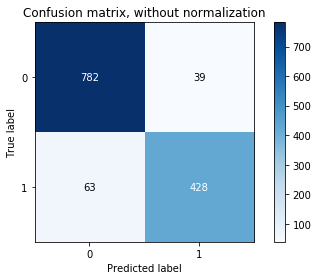

In [8]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### SVC - Predicting the "doubt" expression for subject B

In [9]:
# Report performance against unseen test data
y_B_doubt_pred = svc_grid.predict(X_B_doubt)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.75, precision: 0.61, recall: 0.95, specificity: 0.35'

Confusion matrix, without normalization
[[252 465]
 [ 40 740]]


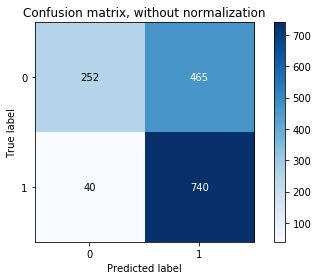

In [10]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### SVC - Classifying "negative" expression using subject A

The original author's model performed poorly on this one (f1 score of 0.44, precision of 0.33, recall of 0.66), so after the apparently easier problem of classifying doubt this should give us our relative performance on a hard problem.

In [11]:
# Load and preprocess the data
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [12]:
random.seed(42)

# model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_A_neg, y_A_neg)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  2.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 0.1}
Score:  0.8110573830010827


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [13]:
# Report performance against the training data
y_A_neg_pred = svc_grid.predict(X_A_neg)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.25, precision: 0.99, recall: 0.14, specificity: 1.00'

Confusion matrix, without normalization
[[595   1]
 [452  76]]


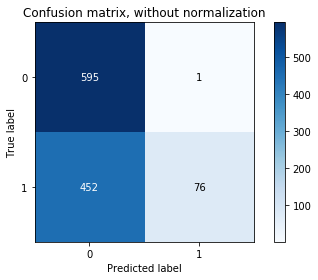

In [14]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

### SVC - Predicting the "negative" expression for subject B

In [15]:
# Report performance against unseen test data
y_B_neg_pred = svc_grid.predict(X_B_neg)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.01, precision: 0.67, recall: 0.00, specificity: 1.00'

Confusion matrix, without normalization
[[869   1]
 [710   2]]


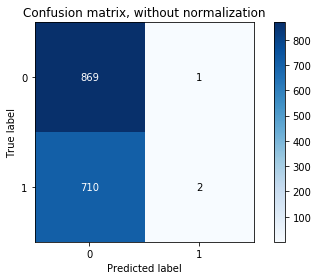

In [16]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

# c)  Additional Analysis of classifiers - reverse roles!
Train on B, classify A, comment on difference!
Try again using a different feature representation (eg; PCA.  Can I think of something better?)

### SVC - Classifying "doubt" expression using subject B (REVERSE)

In [17]:
random.seed(42)

# Model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_B_doubt, y_B_doubt)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  3.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 10000000.0}
Score:  0.8068364406956108


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [18]:
# Report performance against the training data
y_B_doubt_pred = svc_grid.predict(X_B_doubt)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.78, precision: 0.96, recall: 0.66, specificity: 0.97'

Confusion matrix, without normalization
[[695  22]
 [263 517]]


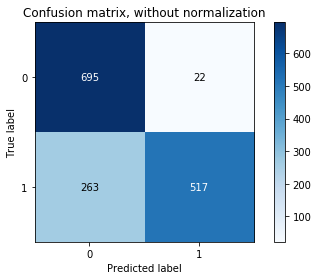

In [19]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### SVC - Predicting the "doubt" expression for subject A

In [20]:
# Report performance against unseen test data
y_A_doubt_pred = svc_grid.predict(X_A_doubt)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.31, precision: 0.24, recall: 0.45, specificity: 0.13'

Confusion matrix, without normalization
[[108 713]
 [270 221]]


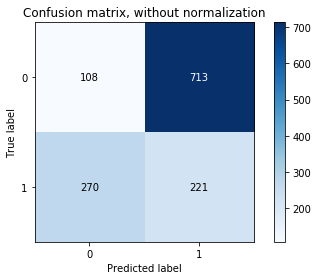

In [21]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### SVC - Classifying "negative" expression using subject B (REVERSE)

In [22]:
random.seed(42)

# model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_B_neg, y_B_neg)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  3.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 0.1}
Score:  0.6661853953554552


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
# Report performance against unseen test data
y_B_neg_pred = svc_grid.predict(X_B_neg)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.79, precision: 0.89, recall: 0.70, specificity: 0.93'

Confusion matrix, without normalization
[[809  61]
 [212 500]]


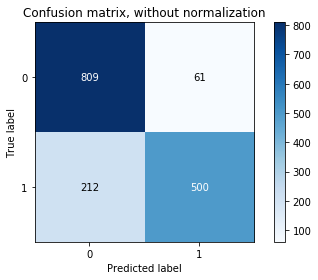

In [24]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### SVC - Predicting the "negative" expression for Subject A

In [25]:
# Report performance against unseen test data
y_A_neg_pred = svc_grid.predict(X_A_neg)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.38, precision: 0.39, recall: 0.37, specificity: 0.48'

Confusion matrix, without normalization
[[288 308]
 [332 196]]


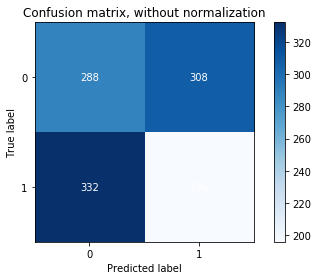

In [26]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

## Trying a new data representation - independent scaling

This is cheating a little - I'm not changing the feature representation much, but it addresses an important issue in this dataset in an appropriate way.

A model trained on one user doesn't translate well to another.  This could well be because the model currently depends on absolute positions of features that may be quite different for different people's faces or poses.  To fix this, rather than try anything clever like PCA I'm simply going to independently scale every feature for subject A and subject B.  I'll try something clever in the next section, I promise.

It's independent for each subject. The assumptions made are that this will help the model pick out the range of movement of features rather than their absolute positions, and that the same features will move in the same way for different subjects.

### SVC + Scaling - Classifying "doubt" expression using subject A

In [27]:
# Load and preprocess the data
X_A_doubt, y_A_doubt = load_features_and_labels("a", "doubt_question")
X_B_doubt, y_B_doubt = load_features_and_labels("b", "doubt_question")

# Load and preprocess the data
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

# Scale all features
scaler = StandardScaler()
X_A_doubt_s = scaler.fit(X_A_doubt).transform(X_A_doubt)
X_B_doubt_s = scaler.fit(X_B_doubt).transform(X_B_doubt)
X_A_neg_s = scaler.fit(X_A_neg).transform(X_A_neg)
X_B_neg_s = scaler.fit(X_B_neg).transform(X_B_neg)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [28]:
random.seed(42)

# Model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_A_doubt_s, y_A_doubt)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  1.4min finished


{'SVM__C': 0.01}
Score:  0.8969088054268233


In [29]:
# Report performance against the training data
y_A_doubt_pred = svc_grid.predict(X_A_doubt_s)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.92, precision: 0.94, recall: 0.90, specificity: 0.97'

Confusion matrix, without normalization
[[795  26]
 [ 48 443]]


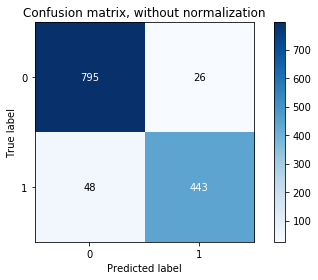

In [30]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### SVC + Scaling Predicting the "doubt" expression for subject B

In [31]:
# Report performance against unseen test data
y_B_doubt_pred = svc_grid.predict(X_B_doubt_s)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.85, precision: 0.85, recall: 0.84, specificity: 0.84'

Confusion matrix, without normalization
[[605 112]
 [125 655]]


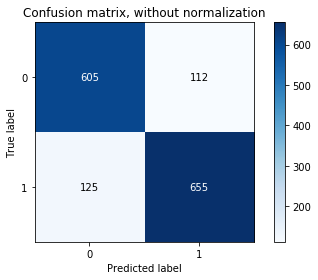

In [32]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### SVC + Scaling - Classifying "negative" expression using subject A

In [33]:
random.seed(42)

# model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_A_neg_s, y_A_neg)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  1.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 0.01}
Score:  0.9024392777893201


In [34]:
# Report performance against the training data
y_A_neg_pred = svc_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.91, precision: 0.92, recall: 0.91, specificity: 0.93'

Confusion matrix, without normalization
[[557  39]
 [ 50 478]]


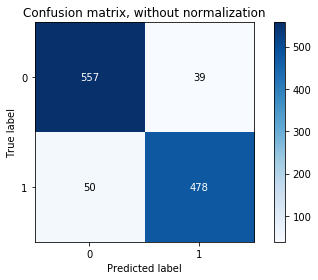

In [35]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

### SVC + Scaling - Predicting the "negative" expression for subject B

In [36]:
# Report performance against unseen test data
y_B_neg_pred = svc_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.53, precision: 0.51, recall: 0.54, specificity: 0.58'

Confusion matrix, without normalization
[[506 364]
 [327 385]]


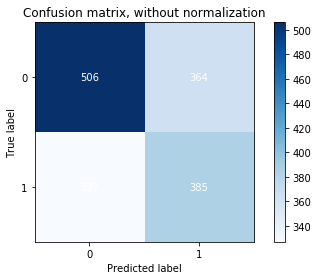

In [37]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### SVC + Scaling - Classifying the "doubt" expression using subject B (REVERSE)

In [38]:
random.seed(42)

# Model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_B_doubt_s, y_B_doubt)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  2.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 0.01}
Score:  0.888685909090732


In [39]:
# Report performance against the training data
y_B_doubt_pred = svc_grid.predict(X_B_doubt_s)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.94, precision: 0.94, recall: 0.94, specificity: 0.93'

Confusion matrix, without normalization
[[670  47]
 [ 49 731]]


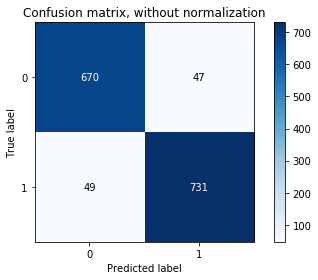

In [40]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### SVC + Scaling - Predicting the "doubt" expression for subject A

In [41]:
# Report performance against unseen test data
y_A_doubt_pred = svc_grid.predict(X_A_doubt_s)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.87, precision: 0.85, recall: 0.90, specificity: 0.91'

Confusion matrix, without normalization
[[745  76]
 [ 51 440]]


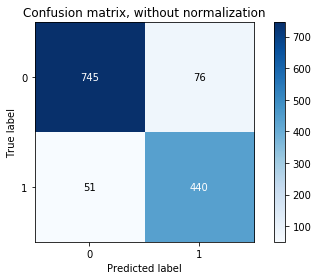

In [42]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### SVC + Scaling - Classifying "negative" expression using subject B (REVERSE)

In [43]:
random.seed(42)

# model defined at start of section
svc_grid = setup_svc()

# Fit the model!
svc_grid.fit(X_B_neg_s, y_B_neg)

# What hyper-parameter combination was chosen?
print(svc_grid.best_params_)

# Report on performance!
print("Score: ", svc_grid.best_score_)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:  2.7min finished


{'SVM__C': 10000.0}
Score:  0.708477460390038


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [44]:
# Report performance against the training data
y_B_neg_pred = svc_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.81, precision: 0.86, recall: 0.77, specificity: 0.90'

Confusion matrix, without normalization
[[781  89]
 [166 546]]


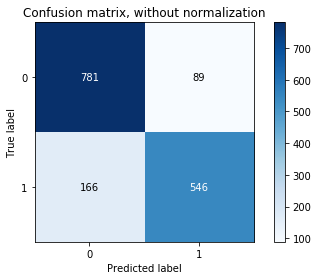

In [45]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### SVC + Scaling - Predicting the "negative" expression for subject A

In [46]:
# Report performance against unseen test data
y_A_neg_pred = svc_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.52, precision: 0.49, recall: 0.55, specificity: 0.48'

Confusion matrix, without normalization
[[289 307]
 [237 291]]


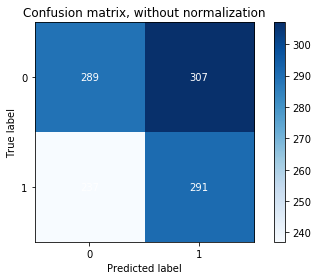

In [47]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

# d)  pt1 - Implement a different classifier

Training on single expression, testing (on B?) and extra marks for own implementation
Training and testing on a SECOND expression.
The same by inverting roles
Repeating with a different feature representation again!  
REF;  for last, try multiclass classifier on principle there should be some shared information?  Data imbalance problem

For this, because I'm getting bored, we're going to skip a few steps.  I'm going to train a Gradient Boosted Trees algorithm on the "doubts" question subject A, evaluate on B, and then I'm going to implement NNMF and see how that improves things.  I'll invert roles if I feel like it, I'm feeling bored of that game after 12 confusion matrices so far.

I'm maintaining independent scaling of subject's features since it was so useful in the last step too.

In [48]:
# This is the model we're going to use for section d.
def setup_gbt(cv=10,
              pipe_list = [('GBT', XGBClassifier(n_estimators=300))],
              gbt_parameters = {'GBT__max_depth':range(2, 11)}):
    """ Helper function.  Lots of bits for setting up a grid-search
    for gbt.
    """
    gbt_pipeline = Pipeline(pipe_list)

    # Set up a cross-validated grid search
    gbt_grid = GridSearchCV(gbt_pipeline,                # tasks to perform
                            param_grid = gbt_parameters, # parameters to try
                            cv=cv,                       # num cv folds
                            scoring='f1',          # score on accuracy
                            n_jobs=-1,                   # use all processors in parallel
                            verbose=True)
    
    return(gbt_grid)

# This is the model we're going to use for section d.
# Fun fact:  If each pipeline component doesn't have at least
# one named argument this fails for no good reason!
def setup_gbt_nmf(cv=10,
                  pipe_list = [('NMF', NMF(solver="cd")),
                               ('GBT', XGBClassifier(n_estimators=300))],
                  gbt_parameters = {'GBT__max_depth':range(2, 11),
                                    'NMF__n_components':[26, 28, 29, 30, 31, 32, 34, 36]}):
    """ Helper function.  Lots of bits for setting up a grid-search
    for gbt.
    """
    gbt_pipeline = Pipeline(pipe_list)

    # Set up a cross-validated grid search
    gbt_grid = GridSearchCV(gbt_pipeline,                # tasks to perform
                            param_grid = gbt_parameters, # parameters to try
                            cv=cv,                       # num cv folds
                            scoring='f1',          # score on accuracy
                            n_jobs=-1,                   # use all processors in parallel
                            verbose=True)
    
    return(gbt_grid)

In [49]:
# Load and preprocess the data
X_A_doubt, y_A_doubt = load_features_and_labels("a", "doubt_question")
X_B_doubt, y_B_doubt = load_features_and_labels("b", "doubt_question")

# Load and preprocess the data
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

# Scale all features
scaler = StandardScaler()
X_A_doubt_s = scaler.fit(X_A_doubt).transform(X_A_doubt)
X_B_doubt_s = scaler.fit(X_B_doubt).transform(X_B_doubt)
X_A_neg_s = scaler.fit(X_A_neg).transform(X_A_neg)
X_B_neg_s = scaler.fit(X_B_neg).transform(X_B_neg)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


### GBT + Scaling - Classifying the "doubt" expression using subject A

In [50]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt()

# Fit the model!
gbt_grid.fit(X_A_doubt_s, y_A_doubt)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.5min finished


{'GBT__max_depth': 7}
Score:  0.895303328002232


In [51]:
# Report performance against the training data
y_A_doubt_pred = gbt_grid.predict(X_A_doubt_s)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 1.00, precision: 1.00, recall: 1.00, specificity: 1.00'

Confusion matrix, without normalization
[[821   0]
 [  0 491]]


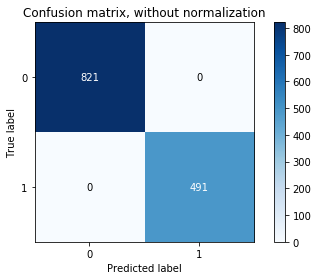

In [52]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### GBT + Scaling -  Predicting the "doubt" expression for subject B

In [53]:
# Report performance against unseen test data
y_B_doubt_pred = gbt_grid.predict(X_B_doubt_s)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.84, precision: 0.83, recall: 0.87, specificity: 0.80'

Confusion matrix, without normalization
[[574 143]
 [105 675]]


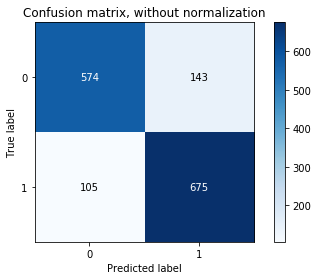

In [54]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### GBT + Scaling - Classifying the "negative" expression using subject A

In [55]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt()

# Fit the model!
gbt_grid.fit(X_A_neg_s, y_A_neg)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'GBT__max_depth': 5}
Score:  0.8890160143060869


In [56]:
# Report performance against the training data
y_A_neg_pred = gbt_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 1.00, precision: 1.00, recall: 1.00, specificity: 1.00'

Confusion matrix, without normalization
[[596   0]
 [  0 528]]


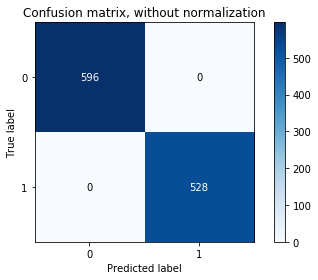

In [57]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

### GBT + Scaling - Predicting the "negative" expression for subject B

In [58]:
# Report performance against unseen test data
y_B_neg_pred = gbt_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.54, precision: 0.44, recall: 0.68, specificity: 0.29'

Confusion matrix, without normalization
[[252 618]
 [226 486]]


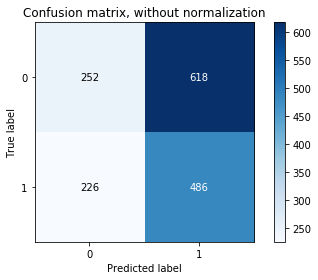

In [59]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### GBT + Scaling - Classifying the "doubt" expression using subject B (REVERSE)

In [60]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt()

# Fit the model!
gbt_grid.fit(X_B_doubt_s, y_B_doubt)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.7min finished


{'GBT__max_depth': 3}
Score:  0.884974211833123


In [61]:
# Report performance against the training data
y_B_doubt_pred = gbt_grid.predict(X_B_doubt_s)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 1.00, precision: 1.00, recall: 1.00, specificity: 1.00'

Confusion matrix, without normalization
[[717   0]
 [  0 780]]


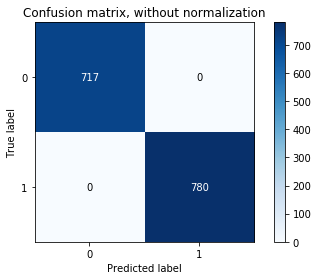

In [62]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### GBT + Scaling - Predicting the "doubt" expression for subject A

In [63]:
# Report performance against unseen test data
y_A_doubt_pred = gbt_grid.predict(X_A_doubt_s)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.84, precision: 0.83, recall: 0.86, specificity: 0.89'

Confusion matrix, without normalization
[[733  88]
 [ 69 422]]


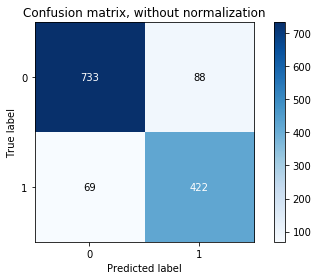

In [64]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### GBT + Scaling - Classifying the "negative" expression using subject B (REVERSE)

In [65]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt()

# Fit the model!
gbt_grid.fit(X_B_neg_s, y_B_neg)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 13.8min finished


{'GBT__max_depth': 9}
Score:  0.6994631702889667


In [66]:
# Report performance against the training data
y_B_neg_pred = gbt_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 1.00, precision: 1.00, recall: 1.00, specificity: 1.00'

Confusion matrix, without normalization
[[870   0]
 [  0 712]]


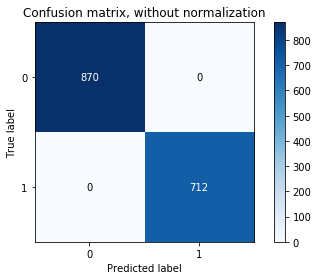

In [67]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### GBT + Scaling - Predicting the "negative" expression for subject A

In [68]:
# Report performance against unseen test data
y_A_neg_pred = gbt_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.64, precision: 0.52, recall: 0.81, specificity: 0.35'

Confusion matrix, without normalization
[[208 388]
 [100 428]]


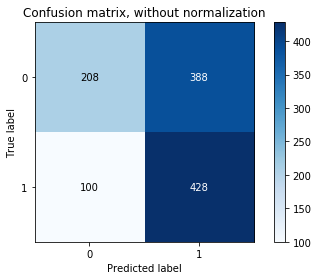

In [69]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

# d) pt2 - XGBoost applied to Non-Negative Matrix Factorisation (NMF) representation

In [70]:
# Load and preprocess the data
X_A_doubt, y_A_doubt = load_features_and_labels("a", "doubt_question")
X_B_doubt, y_B_doubt = load_features_and_labels("b", "doubt_question")

# Load and preprocess the data
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

# Scale all features
scaler = StandardScaler()
X_A_doubt_s = scaler.fit(X_A_doubt).transform(X_A_doubt)
X_B_doubt_s = scaler.fit(X_B_doubt).transform(X_B_doubt)
X_A_neg_s = scaler.fit(X_A_neg).transform(X_A_neg)
X_B_neg_s = scaler.fit(X_B_neg).transform(X_B_neg)

# Shift_Factor (necessary to make all numbers non-negative)
shift_factor_doubt = min(np.min(X_A_doubt_s), np.min(X_B_doubt_s))
X_A_doubt_s -= shift_factor_doubt
X_B_doubt_s -= shift_factor_doubt

shift_factor_neg = min(np.min(X_A_neg_s), np.min(X_B_neg_s))
X_A_neg_s -= shift_factor_neg
X_B_neg_s -= shift_factor_neg

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


### GBT + Scaling + NMF - Classifying the "doubt" expression using subject A

In [71]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt_nmf()

# Fit the model!
gbt_grid.fit(X_A_doubt_s, y_A_doubt)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 53.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'GBT__max_depth': 8, 'NMF__n_components': 31}
Score:  0.8796446230562064


In [72]:
# Report performance against the training data
y_A_doubt_pred = gbt_grid.predict(X_A_doubt_s)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.95, precision: 0.96, recall: 0.94, specificity: 0.97'

Confusion matrix, without normalization
[[800  21]
 [ 29 462]]


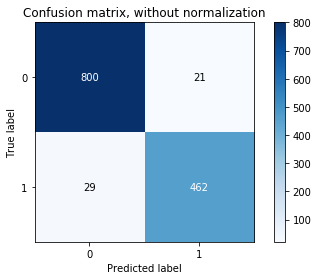

In [73]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### GBT + Scaling + NMF -  Predicting the "doubt" expression for subject B

In [74]:
# Report performance against unseen test data
y_B_doubt_pred = gbt_grid.predict(X_B_doubt_s)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.85, precision: 0.84, recall: 0.86, specificity: 0.83'

Confusion matrix, without normalization
[[594 123]
 [111 669]]


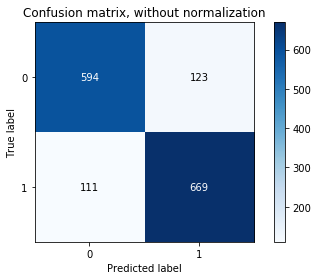

In [75]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### GBT + Scaling + NMF - Classifying the "negative" expression using subject A

In [76]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt_nmf()

# Fit the model!
gbt_grid.fit(X_A_neg_s, y_A_neg)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 40.9min finished


{'GBT__max_depth': 7, 'NMF__n_components': 29}
Score:  0.9002988232603742


In [77]:
# Report performance against the training data
y_A_neg_pred = gbt_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.97, precision: 0.98, recall: 0.97, specificity: 0.98'

Confusion matrix, without normalization
[[585  11]
 [ 16 512]]


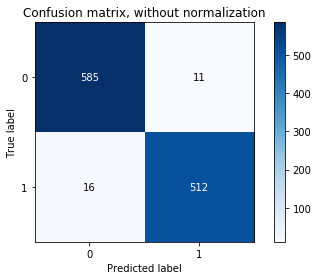

In [78]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

### GBT + Scaling + NMF - Predicting the "negative" expression for subject B

In [79]:
# Report performance against unseen test data
y_B_neg_pred = gbt_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.57, precision: 0.49, recall: 0.68, specificity: 0.42'

Confusion matrix, without normalization
[[367 503]
 [230 482]]


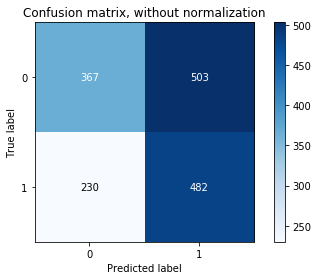

In [80]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### GBT + Scaling + NMF - Classifying the "doubt" expression using subject B (REVERSE)

In [81]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt_nmf()

# Fit the model!
gbt_grid.fit(X_B_doubt_s, y_B_doubt)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 62.1min finished


{'GBT__max_depth': 10, 'NMF__n_components': 36}
Score:  0.880074757381978


In [82]:
# Report performance against the training data
y_B_doubt_pred = gbt_grid.predict(X_B_doubt_s)
make_measurements(y_B_doubt, y_B_doubt_pred)

'F1: 0.98, precision: 0.98, recall: 0.98, specificity: 0.98'

Confusion matrix, without normalization
[[703  14]
 [ 14 766]]


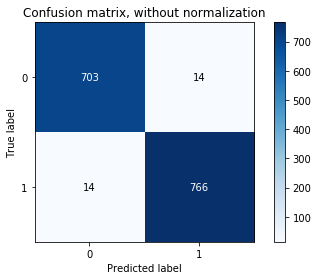

In [83]:
plot_confusion_matrix(y_B_doubt, y_B_doubt_pred)

### GBT + Scaling + NMF -  Predicting the "doubt" expression for subject A

In [84]:
# Report performance against unseen test data
y_A_doubt_pred = gbt_grid.predict(X_A_doubt_s)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.62, precision: 0.48, recall: 0.86, specificity: 0.45'

Confusion matrix, without normalization
[[369 452]
 [ 67 424]]


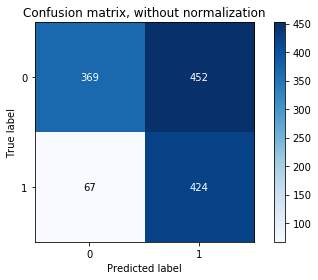

In [85]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### GBT + Scaling + NMF - Classifying the "negative" expression using subject B (REVERSE)

In [86]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt_nmf()

# Fit the model!
gbt_grid.fit(X_B_neg_s, y_B_neg)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 65.0min finished


{'GBT__max_depth': 5, 'NMF__n_components': 31}
Score:  0.7403317408383776


In [87]:
# Report performance against the training data
y_B_neg_pred = gbt_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.99, precision: 0.99, recall: 0.98, specificity: 1.00'

Confusion matrix, without normalization
[[866   4]
 [ 12 700]]


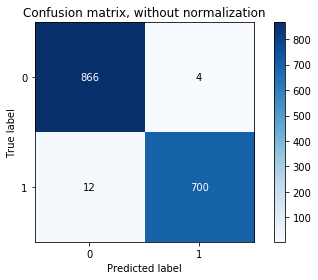

In [88]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### GBT + Scaling + NMF - Predicting the "negative" expression for subject A

In [89]:
# Report performance against unseen test data
y_A_neg_pred = gbt_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.56, precision: 0.60, recall: 0.52, specificity: 0.69'

Confusion matrix, without normalization
[[411 185]
 [251 277]]


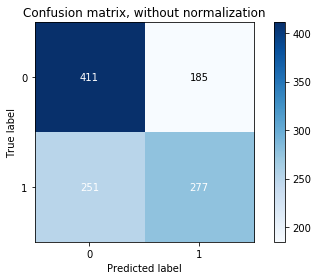

In [90]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

# Scratch-space

Note:  Data augmentation requires reshuffling of data, can't rely on cross-val otherwise!


These results without augmentation

- With NMF(30): 'F1: 0.85, precision: 0.83, recall: 0.87'
- With NMF(31): 'F1: 0.84, precision: 0.84, recall: 0.85'
- Without NMF:  'F1: 0.84, precision: 0.83, recall: 0.87'
- With PCA(45): 'F1: 0.82, precision: 0.82, recall: 0.82'
- With PCA(48): 'F1: 0.83, precision: 0.79, recall: 0.87'

# MAD SCIENCE! - data augmentation instead

In [91]:
def split_data_dimensions(data):
    """ Extract X, Y and Z coordinates from these feature sets."""
    X = np.asarray( [[x[i] for i in range(0, 300, 3)] for x in data] )
    Y = np.asarray( [[x[i] for i in range(1, 300, 3)] for x in data] )
    Z = np.asarray( [[x[i] for i in range(2, 300, 3)] for x in data] )
    return(X, Y, Z)


def generate_skewed_samples(X, Y, factor=0.05, fold=1):
    """ Take X and Y data and skew them randomly, sample by sample. 
    Create as many folds (multiples of original dataset size).
    """
    
    # Create a set of X and Y coordinates for the frame corners
    x_coords = [np.min(X), np.min(X), np.max(X), np.max(X)]
    y_coords = [np.min(Y), np.max(Y), np.min(Y), np.max(Y)]
    
    new_X = []
    new_Y = []
    
    # For (as many times original data as we want)
    for repeats in range(fold):
        for i in range(len(X)):
            
            # Create the four interpolation points with random uniform
            x_skewed = [x + (x_coords[-1]-x_coords[0]) * np.random.uniform(-1, 1) * factor for x in x_coords]
            y_skewed = [y + (y_coords[-1]-y_coords[0]) *np.random.uniform(-1, 1) * factor for y in y_coords]
            
            # create the interpolators
            fx = interp2d(x=x_coords, y=y_coords, z=x_skewed, kind="linear")
            fy = interp2d(x=x_coords, y=y_coords, z=y_skewed, kind="linear")
            
            # Alter all points for a given sample using the same interpolator
            new_X.append([float(fx(X[i, j], Y[i, j])) for j in range(X.shape[1])])
            new_Y.append([float(fy(X[i, j], Y[i, j])) for j in range(X.shape[1])])
        
    return(np.asarray(new_X), np.asarray(new_Y))


def create_augmented_dataset(data, fold=3):
    """ Take a dataset, extract the X and Y coordinates only, and
    augment through random skewing/shearing/jittering (simultaneous).
    
    Return the original data with augmented data appended.
    """
    # Extract just the X and Y variables
    X, Y, Z = split_data_dimensions(data)
    
    # Generate multiple randomly skewed versions (on X and Y only though)
    new_X, new_Y = generate_skewed_samples(X, Y, fold=fold)
    
    # Join original and skewed data into new dataset
    all_X = np.concatenate((X, new_X))
    all_Y = np.concatenate((Y, new_Y))
    #all_Z = np.concatenate([Z for i in range(fold+1)])
    
    # Join into row-wise samples
    return(np.concatenate((all_X, all_Y), axis=1))

### XGBoost + Scaling + Augmentation - Classifying the "negative" expression using subject A

In [92]:
# Load and preprocess the data (negative)
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

# Scale all features
scaler = StandardScaler()
X_A_neg_s = scaler.fit(X_A_neg).transform(X_A_neg)
X_B_neg_s = scaler.fit(X_B_neg).transform(X_B_neg)

# Augment the training datasets four-fold
folds = 4
X_A_neg_s = create_augmented_dataset(X_A_neg_s, fold=folds)

# Extend the training classifications
y_A_neg = np.concatenate([y_A_neg for i in range(folds+1)])

random.seed(42)

# Randomly shuffle the training data
permutation_neg = np.random.permutation(X_A_neg_s.shape[0])
X_A_neg_s = X_A_neg_s[permutation_neg]
y_A_neg = y_A_neg[permutation_neg]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [93]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt()

# Fit the model!
gbt_grid.fit(X_A_neg_s, y_A_neg)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 66.8min finished


{'GBT__max_depth': 10}
Score:  0.9510879303120634


In [94]:
# Report performance against the training data
y_A_neg_pred = gbt_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 1.00, precision: 1.00, recall: 1.00, specificity: 1.00'

Confusion matrix, without normalization
[[2980    0]
 [   0 2640]]


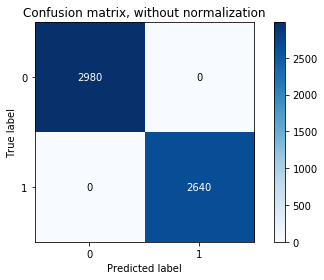

In [95]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

### Predicting the "negative" expression for subject B

- With augmentation: 'F1: 0.62/0.55, precision: 0.54, recall: 0.72'
- With Z removed:    'F1: 0.55, precision: 0.48, recall: 0.65'
- With skew factor 0.2:  'F1: 0.54, precision: 0.52, recall: 0.55'

In [96]:
# Report performance against unseen test data
X, Y, Z = split_data_dimensions(X_B_neg_s)
X_B_neg_s = np.concatenate((X, Y), axis=1)
y_B_neg_pred = gbt_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.60, precision: 0.50, recall: 0.76, specificity: 0.38'

Confusion matrix, without normalization
[[330 540]
 [170 542]]


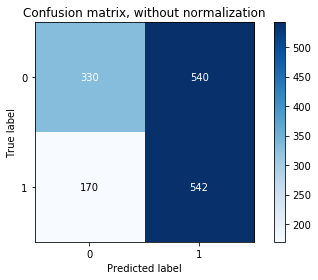

In [97]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### XGBoost + Scaling + Augmentation - Classifying the "negative" expression using subject B  (REVERSE)

In [98]:
# Load and preprocess the data (negative)
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

# Scale all features
scaler = StandardScaler()
X_A_neg_s = scaler.fit(X_A_neg).transform(X_A_neg)
X_B_neg_s = scaler.fit(X_B_neg).transform(X_B_neg)

# Augment the training datasets four-fold
folds = 4
X_B_neg_s = create_augmented_dataset(X_B_neg_s, fold=folds)

# Extend the training classifications
y_B_neg = np.concatenate([y_B_neg for i in range(folds+1)])

random.seed(42)

# Randomly shuffle the training data
permutation_neg = np.random.permutation(X_B_neg_s.shape[0])
X_B_neg_s = X_B_neg_s[permutation_neg]
y_B_neg = y_B_neg[permutation_neg]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [99]:
random.seed(42)

# model defined at start of section
gbt_grid = setup_gbt()

# Fit the model!
gbt_grid.fit(X_B_neg_s, y_B_neg)

# What hyper-parameter combination was chosen?
print(gbt_grid.best_params_)

# Report on performance!
print("Score: ", gbt_grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 101.5min finished


{'GBT__max_depth': 9}
Score:  0.9704812326160513


In [100]:
# Report performance against the training data
y_B_neg_pred = gbt_grid.predict(X_B_neg_s)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 1.00, precision: 1.00, recall: 1.00, specificity: 1.00'

Confusion matrix, without normalization
[[4349    1]
 [   0 3560]]


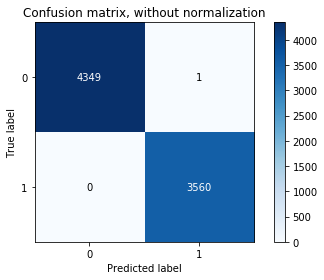

In [101]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

### Predicting the "negative" expression for subject A (REVERSE)

- With augmentation: 'F1: 0.62/0.55, precision: 0.54, recall: 0.72'
- With Z removed:    'F1: 0.55, precision: 0.48, recall: 0.65'
- With skew factor 0.2:  'F1: 0.54, precision: 0.52, recall: 0.55'

In [102]:
# Report performance against unseen test data
X, Y, Z = split_data_dimensions(X_A_neg_s)
X_A_neg_s = np.concatenate((X, Y), axis=1)
y_A_neg_pred = gbt_grid.predict(X_A_neg_s)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.69, precision: 0.66, recall: 0.73, specificity: 0.67'

Confusion matrix, without normalization
[[401 195]
 [144 384]]


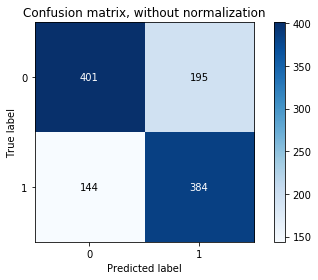

In [103]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)